#### Imports

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#### Import the dataset

In [3]:
circuits = pd.read_csv('./f1_dataset/circuits.csv')
constructor_results = pd.read_csv('./f1_dataset/constructor_results.csv')
constructor_standings = pd.read_csv('./f1_dataset/constructor_standings.csv')
constructors = pd.read_csv('./f1_dataset/constructors.csv')
driver_standings = pd.read_csv('./f1_dataset/driver_standings.csv')
drivers = pd.read_csv('./f1_dataset/drivers.csv')
lap_times = pd.read_csv('./f1_dataset/lap_times.csv')
pit_stops = pd.read_csv('./f1_dataset/pit_stops.csv')
qualifying = pd.read_csv('./f1_dataset/qualifying.csv')
races = pd.read_csv('./f1_dataset/races.csv')
results = pd.read_csv('./f1_dataset/results.csv')
seasons = pd.read_csv('./f1_dataset/seasons.csv')
sprint_results = pd.read_csv('./f1_dataset/sprint_results.csv')
status = pd.read_csv('./f1_dataset/status.csv')

#### For what years do we have lap times, pit stop times?

In [4]:
lap_times_races = pd.merge(lap_times, races, left_on='raceId', right_on='raceId')
lap_times_races["year"].unique()

array([2011, 2012, 2013, 2014, 2015, 2016, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2017,
       2018, 2019, 2020, 2021, 2022, 2023, 2024], dtype=int64)

#### Merge couple of datasets

In [31]:
a = results[["raceId", "driverId", "statusId"]]
b = drivers[["driverId", "forename", "surname"]]
c = status[["statusId", "status"]]
d = races[['raceId', 'year']]

In [32]:
merged_ab = pd.merge(a, b, on="driverId")
merged_abc = pd.merge(merged_ab, c, on="statusId")
merged_abcd = pd.merge(merged_abc, d, on='raceId')

In [34]:
merged_abcd

,raceId,driverId,statusId,forename,surname,status,year
0,18,1,1,Lewis,Hamilton,Finished,2008
1,18,2,1,Nick,Heidfeld,Finished,2008
2,18,3,1,Nico,Rosberg,Finished,2008
3,18,4,1,Fernando,Alonso,Finished,2008
4,18,5,1,Heikki,Kovalainen,Finished,2008
...,...,...,...,...,...,...,...
26514,1116,1,2,Lewis,Hamilton,Disqualified,2023
26515,1116,844,2,Charles,Leclerc,Disqualified,2023
26516,1116,839,130,Esteban,Ocon,Collision damage,2023
26517,1116,4,140,Fernando,Alonso,Undertray,2023


In [35]:
status_counts = merged_abc['status'].value_counts()[:20]

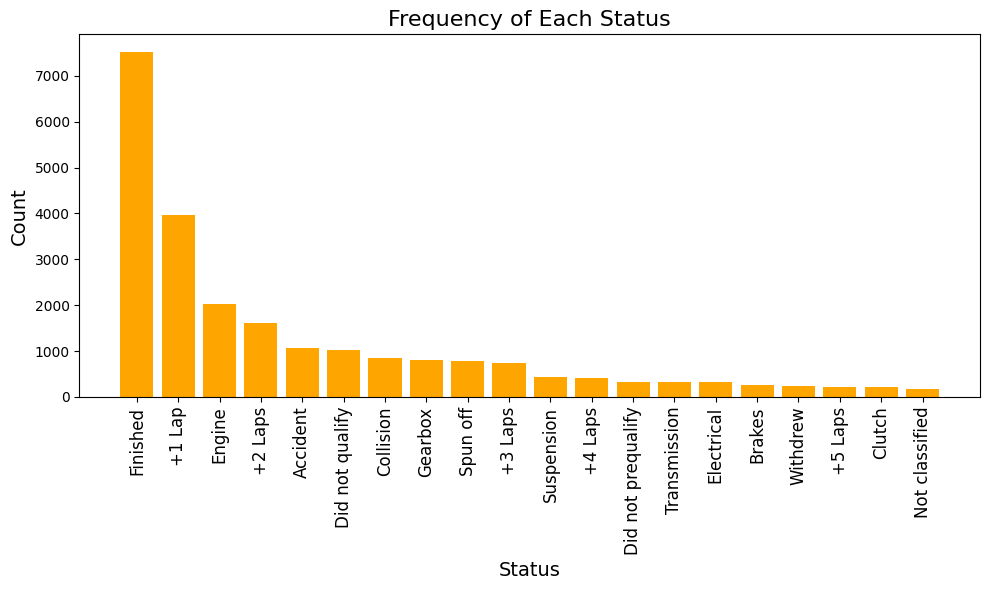

In [36]:
plt.figure(figsize=(10, 6))
plt.bar(status_counts.index, status_counts.values, color='orange')
plt.xticks(rotation=90, fontsize=12)
plt.title('Frequency of Each Status', fontsize=16)
plt.xlabel('Status', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()  # Adjust layout to avoid label overlap
plt.show()

### Further Analysis

In [49]:
year_threshold = 2000

##### Filter the races

In [50]:
filtered_data = merged_abcd[merged_abcd['year'] > year_threshold]
finished_races = filtered_data[filtered_data['status'] == 'Finished']

#### Drivers with the most race finishes?

In [53]:
race_finishes = finished_races.groupby('driverId').size().reset_index(name='finishes')
race_finishes = race_finishes.merge(b, on='driverId')
race_finishes = race_finishes.sort_values(by='finishes', ascending=False)

display(race_finishes.head(10))

,driverId,finishes,forename,surname
0,1,301,Lewis,Hamilton
3,4,253,Fernando,Alonso
19,20,226,Sebastian,Vettel
7,8,221,Kimi,Räikkönen
12,13,167,Felipe,Massa
61,822,164,Valtteri,Bottas
54,815,163,Sergio,Pérez
67,830,158,Max,Verstappen
17,18,157,Jenson,Button
56,817,147,Daniel,Ricciardo


#### Drivers with the most incidents per race ratio:

In [54]:
incident_statuses = ['Accident', 'Retired', 'Collision']
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Calculate total races and incidents per driver
total_races = filtered_data.groupby('driverId').size().reset_index(name='total_races')
total_incidents = incidents.groupby('driverId').size().reset_index(name='total_incidents')

# Merge and calculate ratio
incident_ratio = pd.merge(total_races, total_incidents, on='driverId', how='left').fillna(0)
incident_ratio['incident_per_race'] = incident_ratio['total_incidents'] / incident_ratio['total_races']
incident_ratio = incident_ratio.merge(b, on='driverId')
incident_ratio = incident_ratio.sort_values(by='incident_per_race', ascending=False)

display(incident_ratio.head(20))

,driverId,total_races,total_incidents,incident_per_race,forename,surname
44,45,14,3.0,0.214286,Giorgio,Pantano
41,42,20,4.0,0.200000,Antônio,Pizzonia
23,24,81,15.0,0.185185,Vitantonio,Liuzzi
119,858,33,6.0,0.181818,Logan,Sargeant
117,856,11,2.0,0.181818,Nyck,de Vries
73,812,11,2.0,0.181818,Karun,Chandhok
11,12,28,5.0,0.178571,Nelson,Piquet Jr.
25,26,28,5.0,0.178571,Scott,Speed
24,25,17,3.0,0.176471,Alexander,Wurz
72,811,46,8.0,0.173913,Bruno,Senna


In [58]:
lap_data = pd.merge(lap_times, races[['raceId', 'circuitId']], on='raceId')

In [59]:
lap_data

,raceId,driverId,lap,position,time,milliseconds,circuitId
0,841,20,1,1,1:38.109,98109,1
1,841,20,2,1,1:33.006,93006,1
2,841,20,3,1,1:32.713,92713,1
3,841,20,4,1,1:32.803,92803,1
4,841,20,5,1,1:32.342,92342,1
...,...,...,...,...,...,...,...
575024,1131,858,65,19,1:10.742,70742,70
575025,1131,858,66,19,1:10.855,70855,70
575026,1131,858,67,19,1:12.454,72454,70
575027,1131,858,68,19,1:13.607,73607,70


In [68]:
circuits.head()

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [75]:
avg_lap_time = lap_data.groupby('circuitId')['milliseconds'].mean().reset_index(name='avg_lap_time')

# Merge results with status to identify incidents
incident_statuses = ['Accident', 'Retired', 'Collision']  # Define incident statuses
results_with_status = pd.merge(results, status, on='statusId')
results_with_status = pd.merge(results_with_status, races, on='raceId')

# Filter incidents and calculate incidents perr circuit
incidents = results_with_status[results_with_status['status'].isin(incident_statuses)]
incident_counts = incidents.groupby('circuitId').size().reset_index(name='incident_count')

# Total races per track
total_races = races.groupby('circuitId').size().reset_index(name='total_races')

# Merge incident counts with total races
incident_rate = pd.merge(incident_counts, total_races, on='circuitId', how='right').fillna(0)
incident_rate['incident_rate'] = incident_rate['incident_count'] / incident_rate['total_races']

# Merge avg lap time and incident rate into one dataset
track_difficulty = pd.merge(avg_lap_time, incident_rate[['circuitId', 'incident_rate']], on='circuitId')

# Normalize
scaler = MinMaxScaler()
track_difficulty[['normalized_lap_time', 'normalized_incident_rate']] = scaler.fit_transform(
    track_difficulty[['avg_lap_time', 'incident_rate']]
)

#### Add an interactive widget for defining track difficulty

In [78]:
import ipywidgets as widgets
from IPython.display import display

alpha_slider = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.01,
    description='Alpha:',
    continuous_update=True
)

def update_difficulty_score(alpha):
    beta = 1 - alpha
    track_difficulty['difficulty_score'] = (
        alpha * track_difficulty['normalized_lap_time'] +
        beta * track_difficulty['normalized_incident_rate']
    )

    sorted = track_difficulty[['circuitId', 'difficulty_score']].sort_values(by='difficulty_score', ascending=False)
    td_named = pd.merge(sorted, circuits[['circuitId', 'name']], on='circuitId')
    display(td_named[['circuitId', 'name', 'difficulty_score']].head(10))

widgets.interact(update_difficulty_score, alpha=alpha_slider)


interactive(children=(FloatSlider(value=0.5, description='Alpha:', max=1.0, step=0.01), Output()), _dom_classe…

<function __main__.update_difficulty_score(alpha)>